In [298]:
%load_ext autoreload
%autoreload 2
from predict_np import predict_from_np
from scipy.stats import beta
from shapley_fda import ShapleyFda
from skfda.misc import inner_product
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FourierBasis
from skfda.representation.basis import BSplineBasis
from skfda.representation.grid import FDataGrid
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


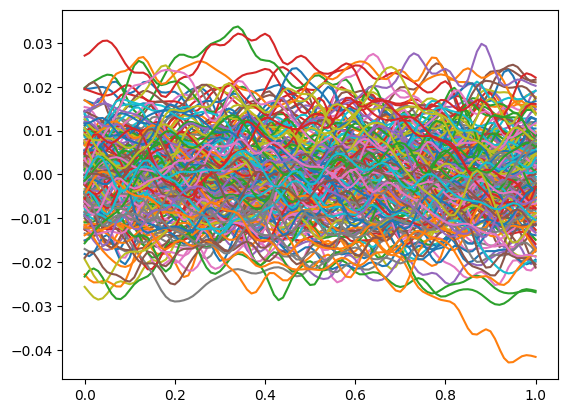

In [299]:
# Build Fourier-related data
num_functions = 200
n_basis_representation = 20
n_basis_simulated_data = 51
ini = 0
end = 1
period = np.pi/2
domain_range = (ini, end)
step = 0.01
abscissa_points = np.arange(ini, end + step, step)
if n_basis_simulated_data % 2 == 0:
    n_basis_simulated_data = n_basis_simulated_data + 1
basis_fourier = FourierBasis(n_basis=n_basis_simulated_data, period=period, domain_range=domain_range)
basis_bsplines = BSplineBasis(n_basis=n_basis_representation, domain_range=domain_range)
total_abscissa_points = abscissa_points.shape[0]
row_vector_ones_total_abscissa_points = np.ones(shape=(1, total_abscissa_points))
col_vector_ones_num_functions = np.ones(shape=(num_functions, 1))
X_simulated = np.empty(shape=(num_functions, total_abscissa_points))
basis_fourier_evaluated = np.squeeze(basis_fourier(abscissa_points))
#lambda_coefficients = np.array([1/(2 ** i) for i in range(1, n_basis_simulated_data + 1)], ndmin=2)
#lambda_coefficients = np.array([1 for i in range(1, n_basis_simulated_data + 1)], ndmin=2)
lambda_coefficients = np.array([1/i for i in range(1, n_basis_simulated_data + 1)], ndmin=2)
lambda_matrix = np.dot(lambda_coefficients.T, row_vector_ones_total_abscissa_points)
for i in range(num_functions):
    np.random.seed(1234 + i)
    normal_vector = np.random.normal(scale=0.01, size=(1, n_basis_simulated_data))
    normal_matrix = np.dot(normal_vector.T, row_vector_ones_total_abscissa_points)
    # Each basis is multiplied by the same coefficient. Therefore, given a basis (a row), we use
    # the same coefficient for all the columns (time)
    coefficients_basis_matrix = np.multiply(normal_matrix, lambda_matrix)
    basis_with_coefficients_matrix = np.multiply(basis_fourier_evaluated, coefficients_basis_matrix)
    sum_basis = np.sum(basis_with_coefficients_matrix, axis=0)
    X_simulated[i, :] = sum_basis
X_simulated_grid = FDataGrid(data_matrix=X_simulated, grid_points=abscissa_points, domain_range=domain_range)
X_basis_fourier = X_simulated_grid.to_basis(basis_fourier)
X_basis_bsplines = X_simulated_grid.to_basis(basis_bsplines)
zzz = X_simulated_grid.plot()

In [266]:
basis_fourier.period

1.5707963267948966

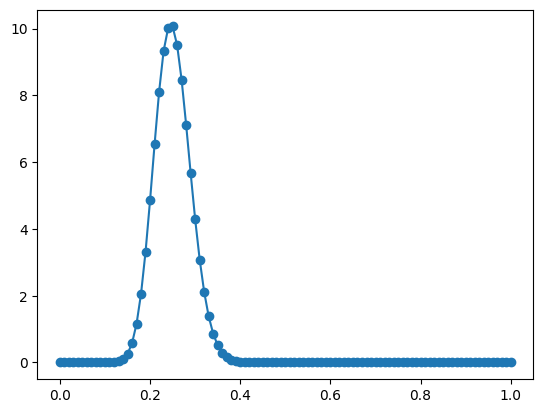

In [300]:
# Build beta distribution data
cnt = 30
alpha_1 =  1 * cnt
beta_1 = 3 * cnt
beta_distr = beta(alpha_1, beta_1)
beta_pdf_abscissa = np.reshape(beta_distr.pdf(abscissa_points), newshape=(1, -1))
beta_pdf_matrix = np.dot(col_vector_ones_num_functions, beta_pdf_abscissa)
plt.plot(abscissa_points, beta_pdf_abscissa[0], '-o')

In [301]:
abscissa_points

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

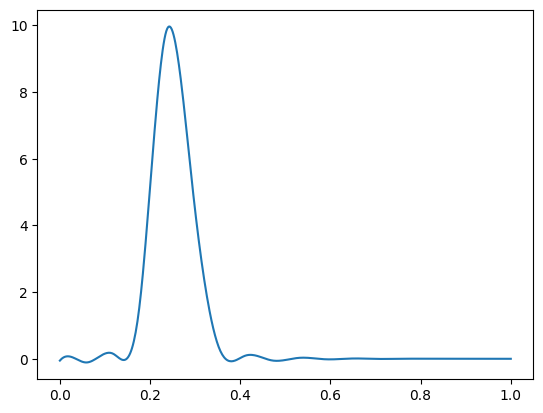

In [302]:
# Transform beta distribution to grid and basis
beta_grid = FDataGrid(
    data_matrix= beta_pdf_abscissa[0],
    grid_points=abscissa_points, 
    domain_range=(ini, end)
)
beta_basis_fourier = beta_grid.to_basis(basis_bsplines)
beta_basis_bsplines = beta_grid.to_basis(basis_bsplines)
zzzz = beta_basis_bsplines.plot()

In [303]:
# Build the target
np.random.seed(12345)
y = inner_product(X_simulated_grid, beta_grid) + np.random.normal(scale=0.001, size=num_functions)

In [304]:
def my_predict(grid_points, domain_range, beta_grid):
    def inner_pred(X):
        X_grid = FDataGrid(
            data_matrix=X,
            grid_points=grid_points, 
            domain_range=domain_range
        )
        result = inner_product(X_grid, beta_grid)
        return result
    return inner_pred

In [305]:
pred_gold = my_predict(abscissa_points, domain_range, beta_grid)

In [321]:
shapley_fda = ShapleyFda(
    predict_fn=pred_gold,
    X=X_simulated,
    abscissa_points=abscissa_points,
    target=y,
    domain_range=domain_range,
    verbose=False,
)
values_shapley = shapley_fda.compute_shapley_value(num_intervals=10, num_permutations=100)

 set_intervals:
 [[0.  0.1]
 [0.1 0.2]
 [0.2 0.3]
 [0.3 0.4]
 [0.4 0.5]
 [0.5 0.6]
 [0.6 0.7]
 [0.7 0.8]
 [0.8 0.9]
 [0.9 1. ]]
 set_permutations: {(0, 8, 6, 1, 4, 5, 9, 7, 2, 3), (0, 2, 1, 9, 5, 6, 8, 7, 3, 4), (8, 2, 0, 6, 4, 7, 5, 9, 1, 3), (6, 2, 8, 1, 9, 3, 0, 5, 7, 4), (4, 6, 1, 5, 2, 8, 3, 0, 7, 9), (1, 7, 3, 0, 4, 9, 6, 5, 8, 2), (4, 0, 6, 1, 3, 8, 5, 2, 7, 9), (3, 5, 7, 1, 4, 9, 8, 0, 6, 2), (1, 0, 2, 5, 6, 8, 4, 9, 3, 7), (0, 8, 2, 4, 9, 1, 7, 3, 6, 5), (9, 7, 5, 6, 1, 8, 0, 2, 4, 3), (2, 0, 3, 1, 9, 4, 5, 7, 6, 8), (5, 6, 9, 8, 0, 3, 4, 1, 2, 7), (3, 9, 0, 5, 8, 4, 2, 1, 6, 7), (7, 8, 9, 4, 1, 5, 6, 3, 0, 2), (5, 3, 2, 7, 8, 4, 0, 1, 9, 6), (5, 3, 0, 7, 4, 2, 9, 6, 8, 1), (7, 2, 0, 9, 5, 1, 6, 8, 3, 4), (6, 9, 7, 4, 3, 5, 2, 8, 1, 0), (4, 5, 0, 2, 7, 1, 9, 3, 8, 6), (0, 3, 4, 7, 5, 2, 1, 8, 9, 6), (3, 2, 9, 8, 7, 6, 1, 0, 4, 5), (9, 1, 0, 2, 6, 3, 7, 4, 8, 5), (9, 2, 7, 3, 5, 1, 8, 0, 4, 6), (0, 7, 2, 5, 1, 4, 6, 3, 8, 9), (0, 1, 2, 9, 3, 8, 7, 6, 4, 5), (8, 7, 1, 6, 9, 0, 4

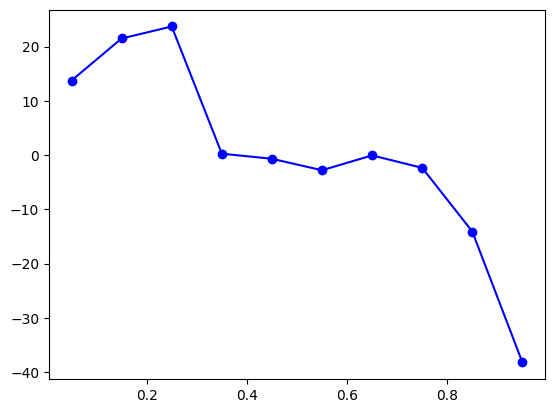

In [322]:
shapley_fda.plot()

In [323]:
covariance_f = np.cov(X_simulated, rowvar=False, bias=True)
sub_matrix = covariance_f[[4,5,6,7,16,17,18,19,20], :][:, [4,5,6,7,16,17,18,19,20]]
eigen_val = np.linalg.eig(sub_matrix)
eigen_val[0]

array([7.36332891e-04, 8.69692820e-05, 7.11734289e-06, 4.67927795e-06,
       8.86114044e-07, 2.73170165e-07, 3.52583331e-08, 5.34861026e-09,
       3.31164990e-10])

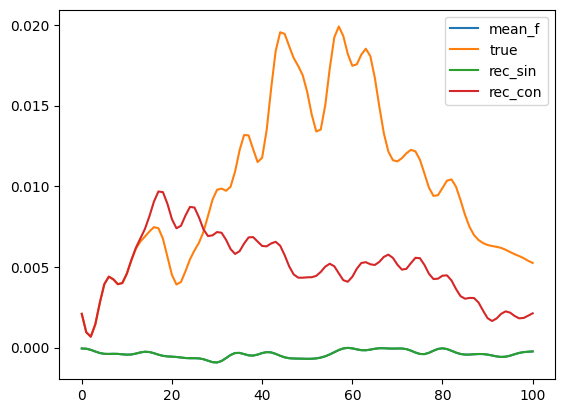

In [324]:
mean_f = np.mean(X_simulated, axis=0)
i = 3
plt.plot(mean_f, label = "mean_f")
plt.plot(X_simulated[i, :], label = "true")
plt.plot(shapley_fda.matrix[0][i, :], label = "rec_sin")
plt.plot(shapley_fda.matrix[1][i, :], label = "rec_con")
plt.legend()
plt.show()

In [326]:
values_shapley

[[array([0. , 0.1]), 13.757464858868689],
 [array([0.1, 0.2]), 21.507181126147927],
 [array([0.2, 0.3]), 23.722780989309744],
 [array([0.3, 0.4]), 0.2568846215769017],
 [array([0.4, 0.5]), -0.6800558878759219],
 [array([0.5, 0.6]), -2.794281814625048],
 [array([0.6, 0.7]), -0.05847190721291739],
 [array([0.7, 0.8]), -2.3569509081172346],
 [array([0.8, 0.9]), -14.110290752023893],
 [array([0.9, 1. ]), -38.25556855320825]]

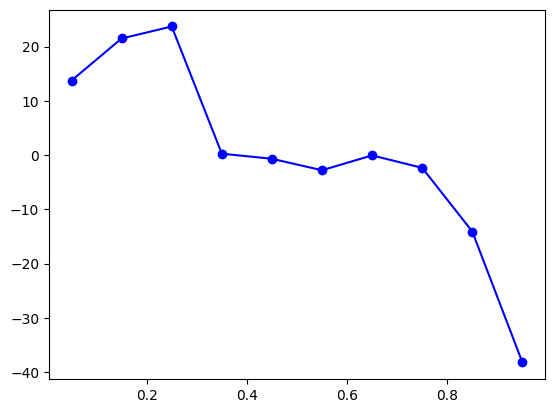

In [329]:
shapley_fda.plot()

In [330]:
# Fit a scikit fda model
X_lm = X_basis_bsplines.copy()
linear_reg = LinearRegression()
_ = linear_reg.fit(X_lm, y)

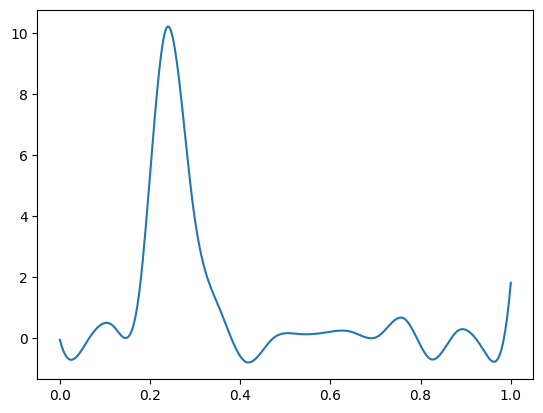

In [331]:
zzz = linear_reg.coef_[0].plot()

In [332]:
# Transform predict function to use a numpy array as input
pred_lm = predict_from_np(
    grid_points=abscissa_points,
    domain_range=domain_range,
    basis=X_lm.basis,
    predict_fn=linear_reg.predict
)

In [334]:
shapley_fda_lm = ShapleyFda(
    predict_fn=pred_lm,
    X=X_simulated,
    abscissa_points=abscissa_points,
    target=y,
    domain_range=domain_range,
    verbose=False,
)
values_shapley_lm = shapley_fda_lm.compute_shapley_value(num_intervals=10, num_permutations=100)

In [124]:
values_shapley_lm

[[array([0. , 0.1]), 0.11972094971706788],
 [array([0.1, 0.2]), 0.06974940730899416],
 [array([0.2, 0.3]), 0.059943114315797616],
 [array([0.3, 0.4]), 0.1970308264190809],
 [array([0.4, 0.5]), 0.14720976986348988],
 [array([0.5, 0.6]), 0.13332265395957676],
 [array([0.6, 0.7]), 0.06894879208188993],
 [array([0.7, 0.8]), 0.05758896563378776],
 [array([0.8, 0.9]), 0.05093714370613871],
 [array([0.9, 1. ]), 0.08841140106139056]]

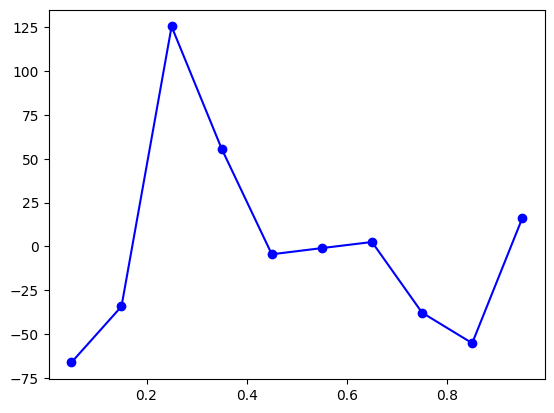

In [335]:
shapley_fda_lm.plot()